# 進出場策略 (Entry & Exit Strategies)

## 看一下單一股票的進出場狀況

In [1]:
%matplotlib inline

import pandas_datareader.data as web
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

In [2]:
# 讀取從指定日期之後的股價資訊
df=web.DataReader("TSLA", 'yahoo', datetime(2016,8,1))

In [3]:
# 計算均線
df['20d'] = np.round(pd.Series.rolling(df['Close'], window=20).mean(), 2)
df['60d'] = np.round(pd.Series.rolling(df['Close'], window=60).mean(), 2)

# 判斷均線向上或向下
df['20d_diff'] = np.round(df['20d'].diff(), 2)
df['60d_diff'] = np.round(df['60d'].diff(), 2)

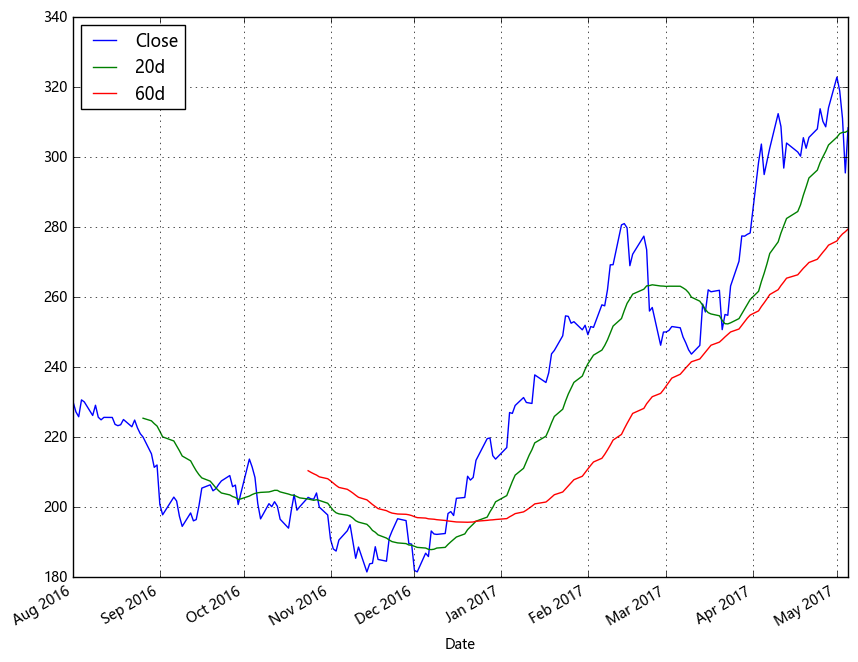

In [4]:
df[['Close','20d','60d']].plot(grid=True, figsize=(10,8))

In [5]:
# Donchian Channel
df['20d_high'] = np.round(pd.Series.rolling(df['Close'], window=20).max(), 2)
df['10d_low'] = np.round(pd.Series.rolling(df['Close'], window=10).min(), 2)

## 策略

進出點的計算，可以參考：

https://www.quantstart.com/articles/Backtesting-a-Moving-Average-Crossover-in-Python-with-pandas

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A165D6C6A0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001A165DC16A0>], dtype=object)

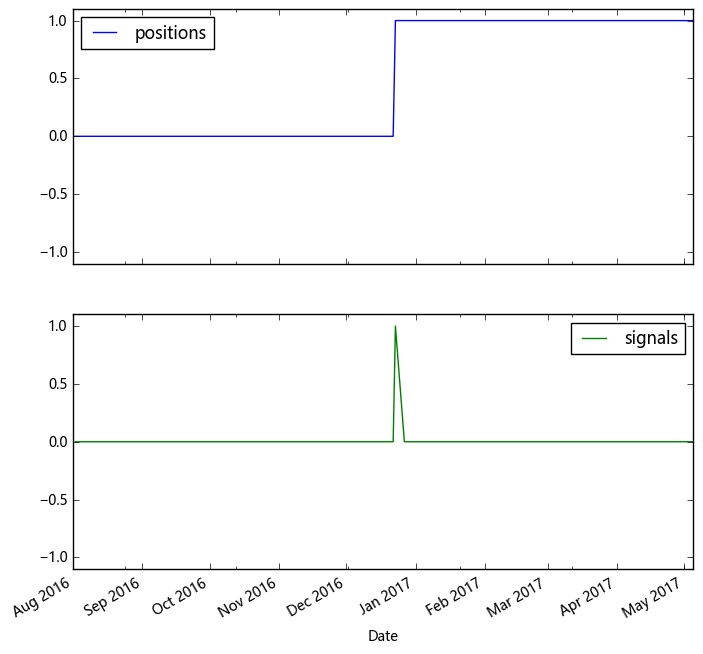

In [11]:
# 第一個策略
df['positions'] = np.where(df['20d']-df['60d'] > 0, 1.0, 0.0)

df['signals'] = df['positions'].diff()

df[['positions', 'signals']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (8, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A166CDD860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001A1669DE7F0>], dtype=object)

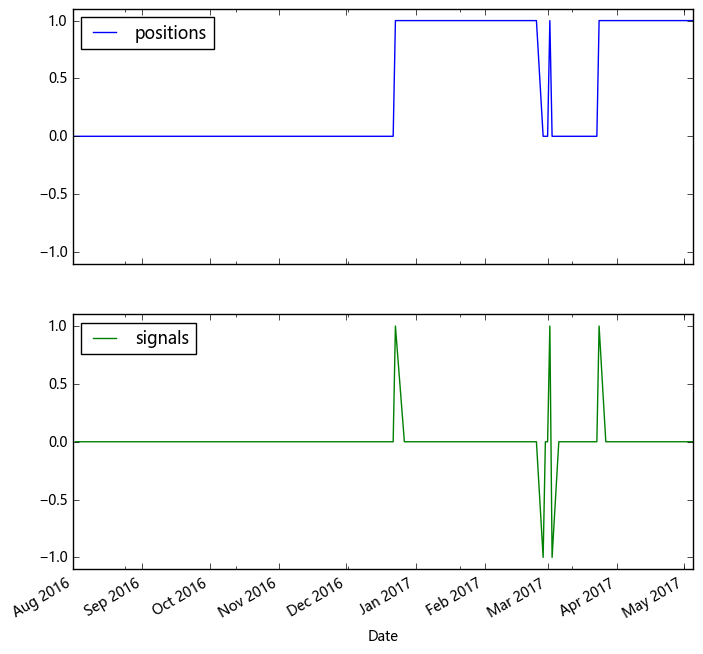

In [12]:
# 第二個策略
df['positions'] = np.where(np.logical_and(df['20d']-df['60d'] > 0, df['20d_diff'] > 0), 1.0, 0.0)

df['signals'] = df['positions'].diff()

df[['positions', 'signals']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (8, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A167FC2BA8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001A167D4B828>], dtype=object)

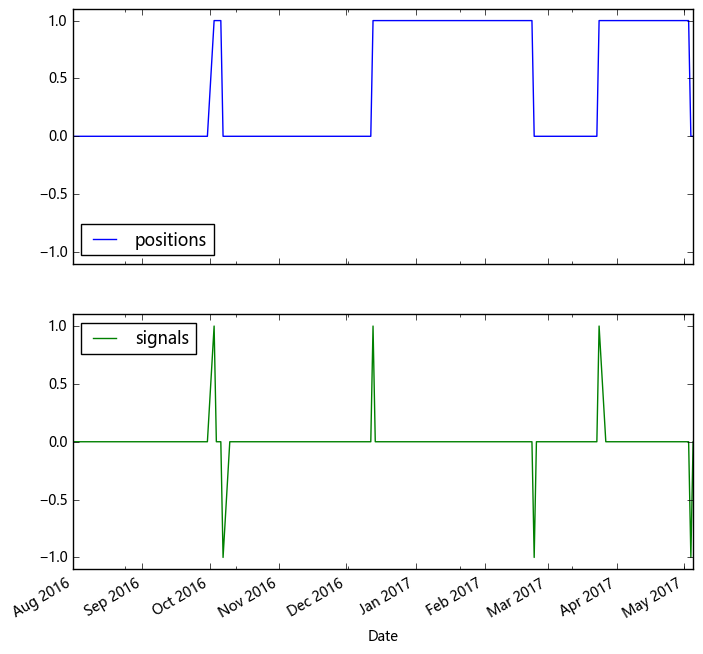

In [13]:
# 第三個策略
has_position = False
df['signals'] = np.zeros(np.size(df['Close']))
for t in range(2, df['signals'].size):
    if df['Close'][t] > df['20d_high'][t-1]:
        if not has_position:
            df.loc[df.index[t], 'signals'] = 1.0
            has_position = True
    elif df['Close'][t] < df['10d_low'][t-1]:
        if has_position:
            df.loc[df.index[t], 'signals'] = -1.0
            has_position = False

df['positions'] = df['signals'].cumsum()

df[['positions', 'signals']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (8, 8))

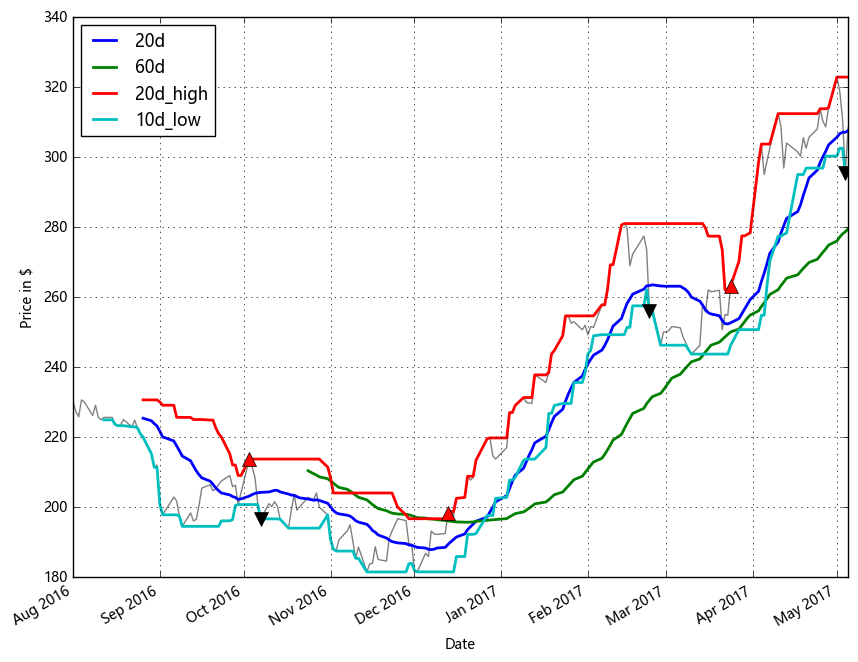

In [14]:
fig = plt.figure()
fig.patch.set_facecolor('white')     # Set the outer colour to white
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
# Plot the AAPL closing price overlaid with the moving averages
df['Close'].plot(ax=ax1, color='gray', lw=1., figsize=(10,8))
df[['20d', '60d']].plot(ax=ax1, lw=2., grid=True)
df[['20d_high', '10d_low']].plot(ax=ax1, lw=2., grid=True)

# Plot the "buy" trades against AAPL
#ax1.plot(df.ix[df.signals == 1.0].index,df['20d'][df.signals == 1.0],'^', markersize=10, color='r')
ax1.plot(df.ix[df.signals == 1.0].index,df['Close'][df.signals == 1.0],'^', markersize=10, color='r')

# Plot the "sell" trades against AAPL
#ax1.plot(df.ix[df.signals == -1.0].index, df['20d'][df.signals == -1.0], 'v', markersize=10, color='k')
ax1.plot(df.ix[df.signals == -1.0].index, df['Close'][df.signals == -1.0], 'v', markersize=10, color='k')

## 計算Sharpe Ratio

In [ ]:
dailyRet = df['Close'].pct_change()

In [ ]:
#假設無風險利率為 4%
#假設一年有252個交易日
excessRet = (dailyRet - 0.04/252)[df['positions']==1.0]

sharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)

In [ ]:
sharpeRatio

## 計算MaxDD跟MaxDDD

In [ ]:
# maxDD: maximum drawdown
# maxDDD: maximum drawdown duration

def calculateMaxDD(cumRet):
    highwatermark = np.zeros(np.size(cumRet))
    drawdownduration = np.zeros(np.size(cumRet))
    drawdown = np.zeros(np.size(cumRet))
    for t in range(2, cumRet.size):
        highwatermark[t] = max(highwatermark[t-1], cumRet[t])
        drawdown[t] = (1 + highwatermark[t]) / (1 + cumRet[t]) - 1
        if (drawdown[t] == 0):
            drawdownduration[t] = 0
        else:
            # 從日期來計算 MaxDDD 的天數
            drawdownduration[t] = drawdownduration[t-1] + (cumRet.index[t]-cumRet.index[t-1]).days
            #drawdownduration[t] = drawdownduration[t-1] + 1
    maxDD = max(drawdown)
    maxDDD = max(drawdownduration)
    Series(drawdownduration, index=cumRet.index).plot()
    return maxDD, maxDDD

In [ ]:
cumRet = np.cumprod(1 + excessRet) - 1

In [ ]:
calculateMaxDD(cumRet)

In [ ]:
cumRet.plot(style='ro-')